**Import the required libraries:**

In [2]:
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sympy import false

In [3]:
# Download NLTK datasets
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to C:\Users\Rajat
[nltk_data]     Shrivastava\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Rajat
[nltk_data]     Shrivastava\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Rajat
[nltk_data]     Shrivastava\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to C:\Users\Rajat
[nltk_data]     Shrivastava\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\Rajat
[nltk_data]     Shrivastava\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Us

True

In [6]:
df=pd.read_csv("data/training_data_lowercase.csv", sep='\t', names=["labels", "text"], header=None)
print(df.columns)
print(df.head())

Index(['labels', 'text'], dtype='object')
   labels                                               text
0       0  donald trump sends out embarrassing new year‚s...
1       0  drunk bragging trump staffer started russian c...
2       0  sheriff david clarke becomes an internet joke ...
3       0  trump is so obsessed he even has obama‚s name ...
4       0  pope francis just called out donald trump duri...


In [7]:

data_train=df["text"]
data_test=df["labels"]

In [8]:
def tokenize_text(text):
    if isinstance(text, str):

        return word_tokenize(text)   # returns a list of tokens
    else:
        return []
data_token=data_train.apply(tokenize_text)

**Remove stop words**

In [9]:
import string


def remove_stop_words(text):

    stop_words = set(stopwords.words('english'))
    words_clean = [word for word in text if word not in stop_words]

    return ' '.join(words_clean)

filter_data=data_token.apply(remove_stop_words)

print(filter_data.head())

0    donald trump sends embarrassing new year‚s eve...
1    drunk bragging trump staffer started russian c...
2    sheriff david clarke becomes internet joke thr...
3    trump obsessed even obama‚s name coded website...
4    pope francis called donald trump christmas speech
Name: text, dtype: object


**Split the data for train and test**

In [10]:
from sklearn.model_selection import train_test_split

X=filter_data
y=data_test

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print(X_train.shape)
print(X_test.shape)



(27321,)
(6831,)


**Load the vectorizer and vectorize the data**

In [11]:
X_train_str = X_train.apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))
X_test_str  = X_test.apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))

tfidf = TfidfVectorizer(
     max_features=5000,
    analyzer='char', ngram_range=(1,5)
)
X_train_tfidf = tfidf.fit_transform(X_train_str)
X_val_tfidf = tfidf.transform(X_test_str)


In [12]:
print(X_val_tfidf.shape)
print(X_train_tfidf.shape)

(6831, 5000)
(27321, 5000)


**Initialize the model and train the model**

In [ ]:
# from sklearn.linear_model import  LogisticRegression
#
# model = LogisticRegression(max_iter=500)
#
# model.fit(X_train_tfidf, y_train)

In [13]:
from xgboost import XGBClassifier

model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
)

model.fit(X_train_tfidf, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [ ]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.svm import SVC
#
# # scaler = StandardScaler()
# # X_scaled = scaler.fit_transform(X_train_tfidf)
#
#
# # Linear kernel
# model = SVC(kernel='linear')
#
# # RBF kernel (non-linear)
# model = SVC(kernel='rbf', C=1.0, gamma='scale')
# model.fit(X_train_tfidf, y_train)

**Create prediction with validation data**

In [17]:
y_pred = model.predict(X_val_tfidf)

**Calculate accuracy score based on prediction**

In [18]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

Accuracy: 0.9568145220319133
              precision    recall  f1-score   support

           0       0.97      0.94      0.96      3529
           1       0.94      0.97      0.96      3302

    accuracy                           0.96      6831
   macro avg       0.96      0.96      0.96      6831
weighted avg       0.96      0.96      0.96      6831



**Confusion matrix based on test and prediction**

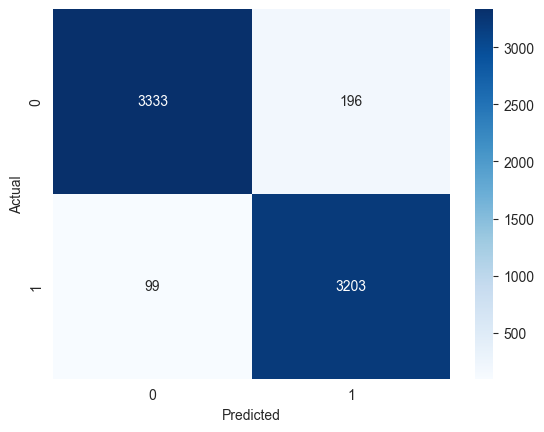

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

**Test the model with load the test data**

In [21]:
test_data=pd.read_csv("data/testing_data_lowercase_nolabels.csv", sep='\t', names=["labels", "text"], header=None)

**Prepocess the test data**

In [22]:
test_data.columns

Index(['labels', 'text'], dtype='object')

In [23]:
test_data["text"].apply(tokenize_text)
test_data["text"].apply(remove_stop_words)
test_data_str  = test_data["text"].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))
tfidf_test_data=tfidf.transform(test_data_str)

Validate

In [25]:
y_pred = model.predict(tfidf_test_data)
test_data["labels"]=y_pred
test_data.to_csv("predictions/testing_data_predictions.csv",header=False, index=False)